## Analyzing Historical Visitation Numbers of U.S. National Parks

This project will analyze the historical visitation counts for each U.S. National Park and attempt to answer the following question: 
 - Are visitation numbers impacted after a park is officially designated as a national park?

https://github.com/carl-schick-ds/national-parks

***
### Setup
Import needed libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import datetime
from IPython.display import display

In [3]:
# Auto Re-load External Modules
%load_ext autoreload
%autoreload 2

***
Configure some global helpers
***

In [4]:
base_year = 1979
this_year = datetime.datetime.today().year
this_year = 2021  ## Process through Dec 2021

***
### Data Collection
The first step of the project is to collect the data from various sources on the internet.  

Data is currently collected from two main sources...
 - The National Park Services' Integrated Resource Management Applications (IRMA) Portal
   - List of official national park unit codes
   - Monthly visitation counts for each national park
 - Wikipedia
   - Location (lat/long), date established, and gross area acres for each national park

Web scraping is performed using the [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) library.  
Fuzzy matching logic for park names is performed using the [The Fuzz (formerly Fuzzy Wuzzy)](https://github.com/seatgeek/thefuzz) library.

National Park data was collected in advance and is stored in 'national_park_data.csv', 'national_park_units.csv', and 'national_park_visits.csv' as part of the git repository.  
Optionally, the National Park data can be refreshed from the IRMA portal and Wikipedia by changing the `REFRESH_DATA` literal to `True`.

In [5]:
# Toggle REFRESH_DATA literal

REFRESH_DATA = True

In [6]:
# Refresh Data
# See the national_parks_dc.py file in this repostitory for details on the data collection routines

if REFRESH_DATA:
    import national_parks_dc as dc

    # Get the data
    park_units_df = dc.get_park_units()
    park_visits_df = dc.get_park_visits(park_units_df)
    park_data_df = dc.get_park_data(park_units_df)

    # Convert to CSV files
    park_units_df.to_csv('national_park_units.csv')
    park_visits_df.to_csv('national_park_visits.csv')
    park_data_df.to_csv('national_park_data.csv')

Processing: ACAD, ARCH, BADL, BIBE, BISC, BLCA, BRCA, CANY, CARE, CAVE, CHIS, CONG, CRLA, CUVA, DENA, DEVA, DRTO, EVER, GAAR, GLAC, GLBA, GRBA, GRCA, GRSA, GRSM, GRTE, GUMO, HALE, HAVO, HOSP, INDU, ISRO, JEFF, JOTR, KATM, KEFJ, KICA, KOVA, LACL, LAVO, MACA, MEVE, MORA, NERI, NOCA, NPSA, OLYM, PEFO, PINN, REDW, ROMO, SAGU, SEQU, SHEN, THRO, VIIS, VOYA, WHSA, WICA, WRST, YELL, YOSE, ZION, 

### Data Loading and Cleaning

#### Load CSVs


Load the data from the csv files and run a quick review of the data for validity checks

In [7]:
# Read in the CSV files
park_visits_df = pd.read_csv('national_park_visits.csv', index_col=[0,1])
park_data_df = pd.read_csv('national_park_data.csv', index_col=0)

# Display the head of each dataframe
display(park_visits_df.head(5))
display(park_data_df.head(5))

ACAD    ARCH   BADL   BIBE   BISC   BLCA    BRCA    CANY  \
Year Month                                                               
2022 JAN     10411   40621  12671  46768  15180   7260   30960   15232   
     FEB     13045   51568  12866  47229  20454   6088   35611   19150   
     MAR     22476  141866  25276  85414  17694   9127  101308   78012   
     APR    105126  148996  34943  59337  18342  13755  236812   99083   
     MAY    327466  172115  98542  40722  39185  30145  299919  114441   

              CARE   CAVE  ...    SHEN   THRO   VIIS   VOYA   WHSA   WICA  \
Year Month                 ...                                              
2022 JAN     20089  20549  ...   13592   2449  25968   4464  45083  12433   
     FEB     25859  21887  ...   34383   2568  21923   5264  44186  11958   
     MAR     90092  48021  ...   56623   6645  27815   3268  99649  20156   
     APR    148686  37869  ...  112635   7366  14174    172  75417  35600   
     MAY    221889  34898  ...  131310  66678   6133  28130  64329  69383   

            WRST    YELL    YOSE    ZION  
Year Month                                
2022 JAN      25   45528  122977  139827  
     FEB      95   47300  149751  168499  
     MAR     230   35616  165570  446308  
     APR     520   79328    4603  491625  
     MAY    4685  523680       0  539172  

[5 rows x 63 columns]

,Name,State,Location,Established,Acres,Description
Code,,,,,,
ACAD,Acadia,Maine,﻿44.35°N 68.21°W,"February 26, 1919","49,071.40",Covering most of Mount Desert Island and other...
NPSA,American Samoa,American Samoa,﻿14.25°S 170.68°W,"October 31, 1988","8,256.67",The southernmost national park is on three Sam...
ARCH,Arches,Utah,﻿38.68°N 109.57°W,"November 12, 1971","76,678.98","This site features more than 2,000 natural san..."
BADL,Badlands,South Dakota,﻿43.75°N 102.50°W,"November 10, 1978","242,755.94","The Badlands are a collection of buttes, pinna..."
BIBE,Big Bend,Texas,﻿29.25°N 103.25°W,"June 12, 1944","801,163.21",Named for the prominent bend in the Rio Grande...


***
Run a quick review of the park visits dataframe
***

In [8]:
# Quick review of Park Visits data
print('Dataframe shape: ', park_visits_df.shape)
print()
print(park_visits_df.info())
print()
print("Count of NA values in each column")
print(park_visits_df.isna().sum())

Dataframe shape:  (528, 63)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 528 entries, (2022, 'JAN') to (1979, 'DEC')
Data columns (total 63 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ACAD    528 non-null    int64
 1   ARCH    528 non-null    int64
 2   BADL    528 non-null    int64
 3   BIBE    528 non-null    int64
 4   BISC    528 non-null    int64
 5   BLCA    528 non-null    int64
 6   BRCA    528 non-null    int64
 7   CANY    528 non-null    int64
 8   CARE    528 non-null    int64
 9   CAVE    528 non-null    int64
 10  CHIS    528 non-null    int64
 11  CONG    528 non-null    int64
 12  CRLA    528 non-null    int64
 13  CUVA    528 non-null    int64
 14  DENA    528 non-null    int64
 15  DEVA    528 non-null    int64
 16  DRTO    528 non-null    int64
 17  EVER    528 non-null    int64
 18  GAAR    528 non-null    int64
 19  GLAC    528 non-null    int64
 20  GLBA    528 non-null    int64
 21  GRBA    528 non-null    int64
 22 

***
Run a quick review of the park data dataframe
***

In [9]:
# Quick review of Park Data data
print('Dataframe shape: ', park_data_df.shape)
print()
print(park_data_df.info())
print()
print("Count of NA values in each column")
print(park_data_df.isna().sum())

Dataframe shape:  (63, 6)

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, ACAD to ZION
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         63 non-null     object
 1   State        63 non-null     object
 2   Location     63 non-null     object
 3   Established  63 non-null     object
 4   Acres        63 non-null     object
 5   Description  63 non-null     object
dtypes: object(6)
memory usage: 3.4+ KB
None

Count of NA values in each column
Name           0
State          0
Location       0
Established    0
Acres          0
Description    0
dtype: int64


***
The row counts look good and there are no NA values to contend with.  
Some data types in park_data are inaccurate, and we will need to merge the data in these datasets for optimal analysis.
We will tackle those next.
***

####  Establish Data Types

Convert the Established column to a date time and convert the Acres column to a float.

In [10]:
# Clean up Park Data by converting Established to datetime and Acres to float
park_data_df['Established'] = pd.to_datetime(park_data_df['Established'])
park_data_df['Acres'] = park_data_df['Acres'].str.replace(',', '').astype(float)

#### Merge the dataframes

Aggregate visits at the annual level and combine the visit data with the park data

In [11]:
def combine_park_data_and_visits(park_data_df, park_visits_df):
    # Sum monthly visits into annual totals and merge the visit totals into the park-data dataframe
    park_annual_visits_df = park_visits_df.groupby(level=0).sum().transpose()
    park_data_combined_df = park_data_df.join(park_annual_visits_df)
    
    return park_data_combined_df

park_data_combined_df = combine_park_data_and_visits(park_data_df, park_visits_df)

***
Filter the dataset to parks that were established after we started counting visits (1979).
***

In [12]:
def filter_park_data(park_data_combined_df):
    # Let's calculate the first year of a Park as their established year, if they were established betwen Jan-June; or the following year if they were established Jul-Dec.
    park_data_combined_df['First Year'] = park_data_combined_df['Established'].apply(lambda x: x.year if x.month <= 6 else x.year + 1)

    # Filter the dataset to parks that were established after we started counting visits (1979).
    park_data_combined_df = park_data_combined_df[park_data_combined_df['First Year'] >= base_year]

    return park_data_combined_df

park_data_combined_df = filter_park_data(park_data_combined_df)


***
Data Cleaning is complete.  Let's take a look at the revised dataset.
***

In [13]:
display(park_data_combined_df.head())

,Name,State,Location,Established,Acres,Description,1979,1980,1981,1982,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,First Year
Code,,,,,,,,,,,,,,,,,,,,,
NPSA,American Samoa,American Samoa,﻿14.25°S 170.68°W,1988-10-31,8256.67,The southernmost national park is on three Sam...,0,0,0,0,...,13953,13892,28892,69468,28626,60006,4819,8495,299,1989
BADL,Badlands,South Dakota,﻿43.75°N 102.50°W,1978-11-10,242755.94,"The Badlands are a collection of buttes, pinna...",858000,952652,1175952,1030484,...,868094,989354,996263,1054325,1008942,970998,916932,1224226,184298,1979
BISC,Biscayne,Florida,﻿25.65°N 80.08°W,1980-06-28,172971.11,"The central part of Biscayne Bay, this mostly ...",202938,248071,305502,348219,...,525745,508164,514709,446961,469253,708522,402770,705655,162881,1980
BLCA,Black Canyon of the Gunnison,Colorado,﻿38.57°N 107.72°W,1999-10-21,30779.83,The park protects a quarter of the Gunnison Ri...,234286,336119,266604,227428,...,183045,209166,238018,307143,308962,432818,341620,308910,66375,2000
CHIS,Channel Islands,California,﻿34.01°N 119.42°W,1980-03-05,249561.00,Five of the eight Channel Islands are protecte...,82937,104574,87514,172287,...,342161,324816,364807,383687,366250,409630,167290,319252,147735,1980


### Data Exploration

#### Setup

Import visualization libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [14]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

***
Configure seaborn
***

In [15]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style('whitegrid')

***
Melt the data so each park has a row for each year from 1979 to present.  This will aid our analysis.
***

In [16]:
def melt_park_data(park_data_combined_df):

    year_columns = [base_year + i for i in range(this_year - base_year + 1)]
    dfm = park_data_combined_df.melt(id_vars=['Name', 'First Year'], value_vars=year_columns, var_name='Year', value_name='Visits').sort_values(by=['Name','Year'])

    return dfm

park_data_melted_df = melt_park_data(park_data_combined_df)
print('Number of parks:', park_data_melted_df['Name'].nunique())
display(park_data_melted_df.head())

Number of parks: 26


,Name,First Year,Year,Visits
0,American Samoa,1989,1979,0
26,American Samoa,1989,1980,0
52,American Samoa,1989,1981,0
78,American Samoa,1989,1982,0
104,American Samoa,1989,1983,0


#### Visualize Visit Increases
There are 26 parks to analyze.  Let's create a lineplot for each chart showing the annual visits from 1979 to present.  
A vertical bar will be placed on each lineplot to indicate the year the park became a National Park.  
Our hypothesis is that annual visits will increase after a park is officially designated as a National Park.

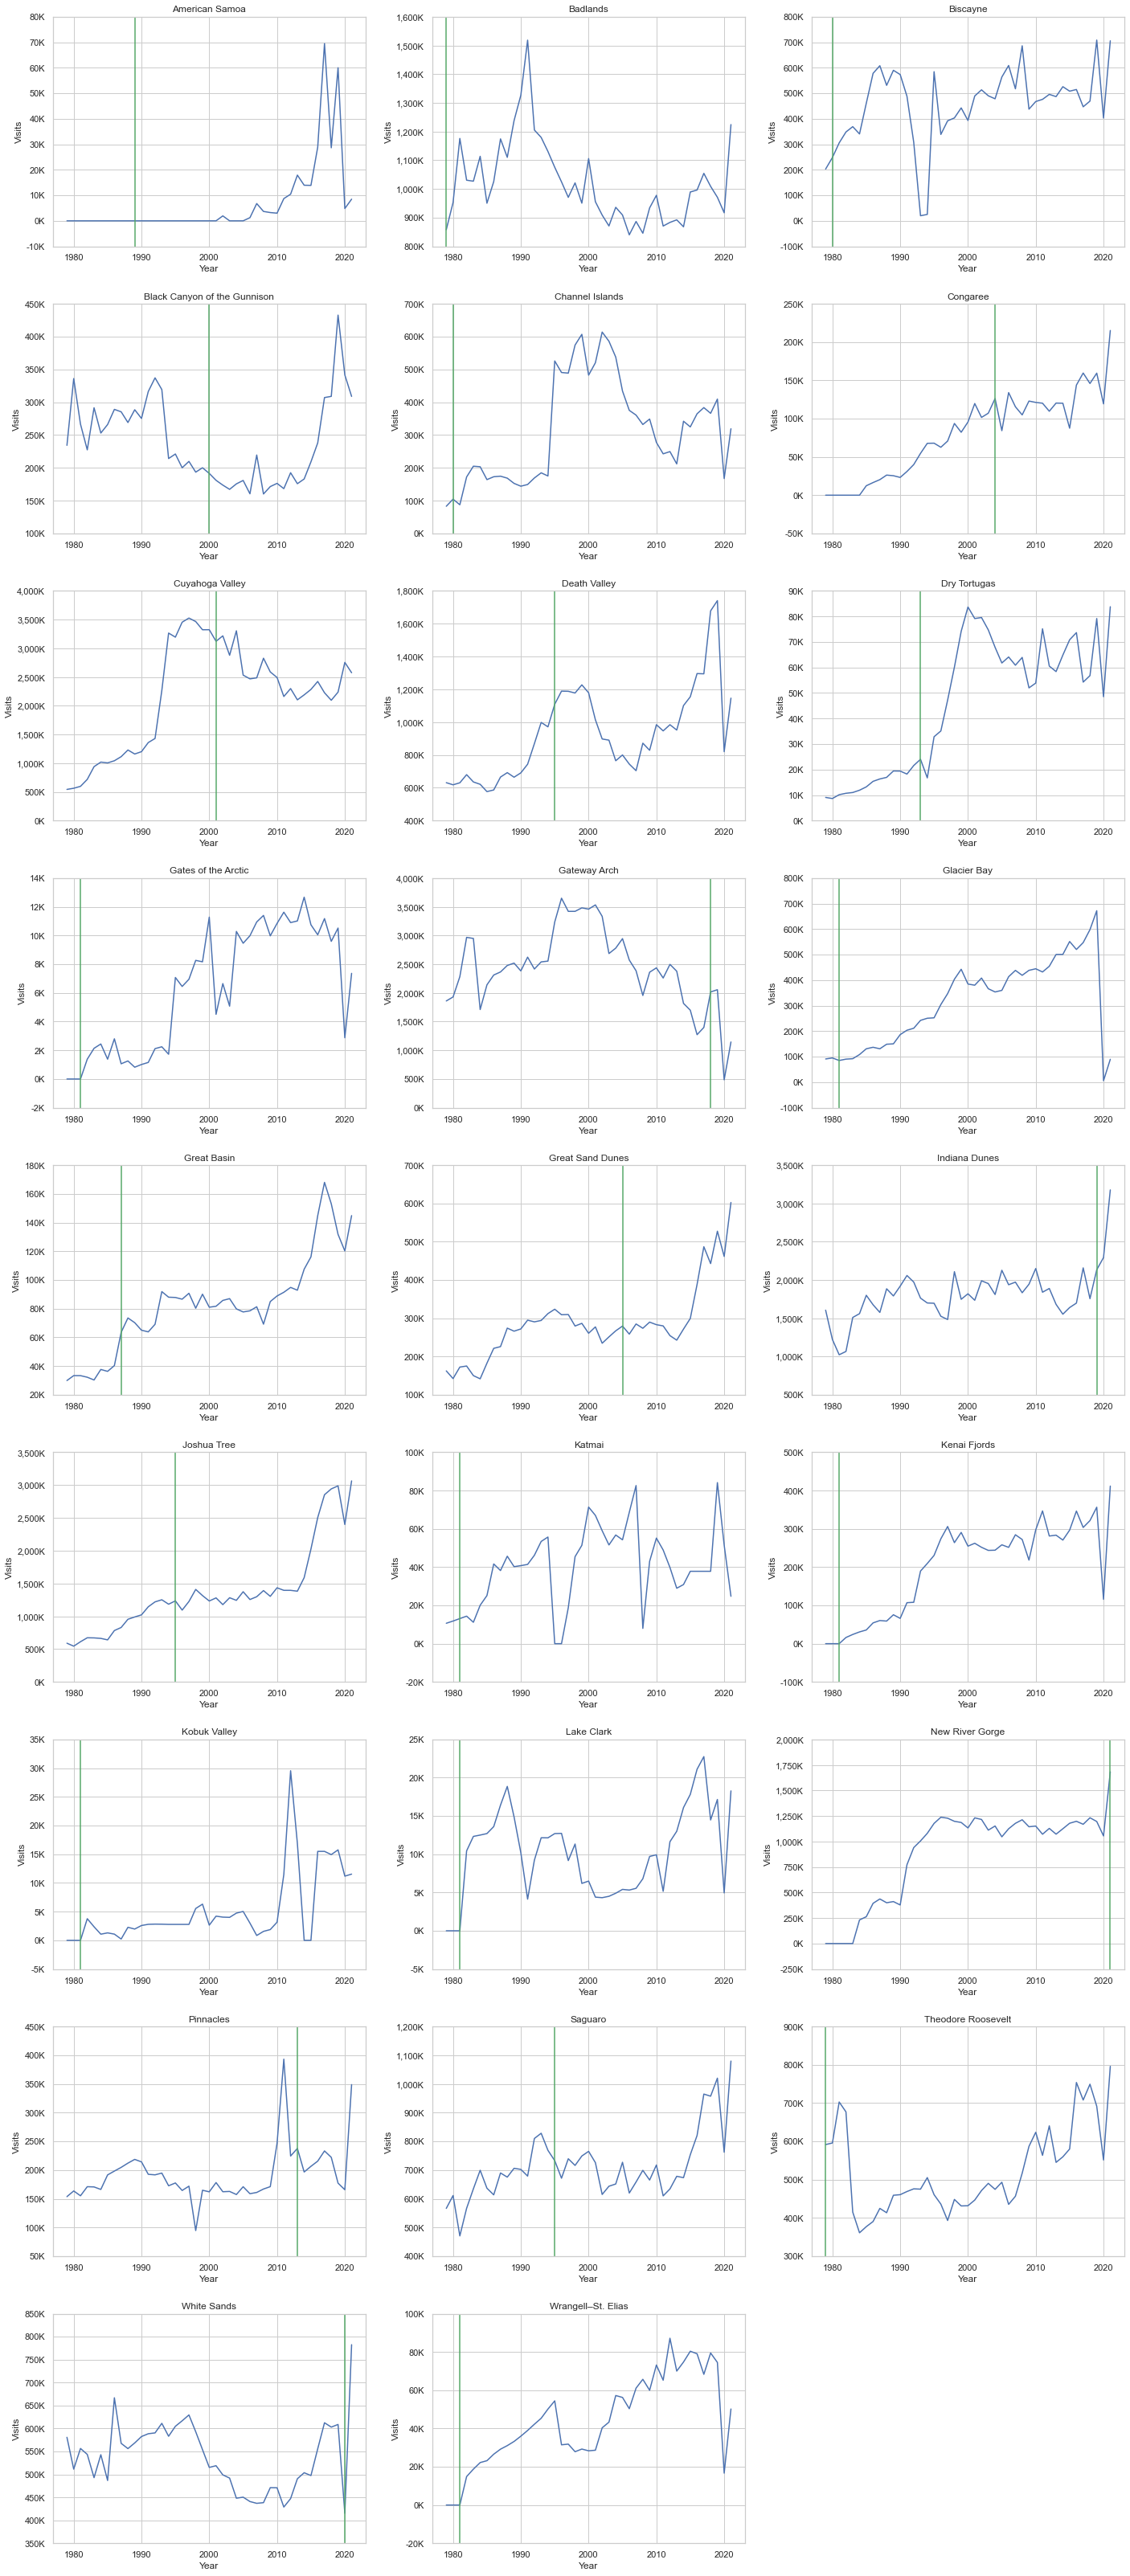

In [17]:
def lineplot_annual_visits(park_data_combined_df):
    # Calculate the plot grid rows.  Columns are fixed at 3.
    num_parks = park_data_combined_df.shape[0]
    num_cols = 3
    num_rows = int(num_parks / num_cols) + 1

    # Setup the plot grid.  The width is fixed at 20 and the height is 5 for each row.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,num_rows * 5), tight_layout=dict(pad=2.0))

    # Plot each park's annual visit counts.
    # Place a green vertical line on the First Year the park was a National Park
    for i, (_, row) in enumerate(park_data_combined_df.iterrows()):
        # Calculate the axis for this park
        ax_row, ax_column = divmod(i, num_cols)
        current_ax = axes[ax_row][ax_column]

        # Create the Lineplot and set the title
        sns.lineplot(data=park_data_melted_df[park_data_melted_df['Name'] == row['Name']], x='Year', y='Visits', ax = current_ax)
        current_ax.set_title(row['Name'])

        # Format the visit ticks to be in thousandths for better readability
        ylabels = ['{:,.0f}'.format(y) + 'K' for y in current_ax.get_yticks()/1000]
        current_ax.set_yticks(current_ax.get_yticks())  ## Only do this to suppress warning about setting tick labels without setting ticks
        current_ax.set_yticklabels(ylabels)
        current_ax.axvline(x=row['First Year'], color='g')

    # The last row might have some extra axes we need to turn off
    for i in range(num_parks, num_rows*num_cols):
        ax_row, ax_column = divmod(i, num_cols)
        current_ax = axes[ax_row][ax_column]
        current_ax.axis('off')

lineplot_annual_visits(park_data_combined_df)

#### Trim Scope
There doesn't seem to be an obvious correlation between National Park designation and an increase in annual visits.  
A few charts hint at an increase, but there isn't a clear pattern.  
In addition, we have some data issues.  
 - COVID resulted in a steep decline in visitors in 2020, so parks established around 2019 cannot be measured.
 - In addition, some parks don't have enough "pre-establishment" counts to determine a "post-establishment" increase.

We will trim the dataset further to only include parks with a least 3 years of data prior to their establishment as a park AND were established at least 3 years prior to COVID.  

In [18]:
def trim_datasets(park_data_combined_df):
    # The first year of the park must be 2017 or earlier in order to have at least 3 years of data prior to COVID.
    pre_covid_test = park_data_combined_df['First Year'] <= 2017
    park_data_combined_df = park_data_combined_df[pre_covid_test]

    # This also means we can also remove 2020 and 2021 data since we are excluding COVID years from the analysis.
    # Ignore an errors if the columns don't exist
    park_data_combined_df = park_data_combined_df.drop(columns=[2020, 2021], errors='ignore')

    # The first year of non-zero visits must be 3 years before the park's "First Year"
    # Create a column that contains the first year with visit counts.  This one needs some explaining...
        # park_data_combined_df.columns[...] will return the name of the column we want.  We are passing in the target index.
        # We find the target_index by first slicing the df to only the Years columns that have visit counts (.loc[:,base_year:]).
        # And from that slice, we get an array of indexes indicating which columns are non-zero for each row of the dataframe (lambda x: x.to_numpy().nonzero()).
        # From each array, we calculate the minimum, which is the first column with non-zero values ([0][0].min()).
        # We add 6 to that minimum since our original slice excluded the first 6 columns of the main dataframe (+ 6).
        # After adding 6, we have the target_index that we can pass to the original columns function to retrieve the first non-zero Year.
    park_data_combined_df['First Count'] = park_data_combined_df.columns[park_data_combined_df.loc[:,base_year:].apply(lambda x: x.to_numpy().nonzero()[0][0].min() + 6, axis=1)]

    # Filter the data to only include park's where the first year of data (First Count) is at least 3 years before the park was established as a national park (First Year)
    data_three_years_back_test = park_data_combined_df['First Count'] <= (park_data_combined_df['First Year'] - 3)
    park_data_combined_df = park_data_combined_df[data_three_years_back_test]

    # Re-do the melt
    year_columns = [base_year + i for i in range(2019 - base_year + 1)]
    park_data_melted_df = park_data_combined_df.melt(id_vars=['Name', 'First Year'], value_vars=year_columns, var_name='Year', value_name='Visits').sort_values(by=['Name','Year'])

    # Return the filtered datasets
    return park_data_combined_df, park_data_melted_df

park_data_combined_df, park_data_melted_df = trim_datasets(park_data_combined_df)
print('Number of parks:', park_data_melted_df['Name'].nunique())

Number of parks: 10


#### Re-Visualize Visit Increases
We are down to 10 parks to analyze.  Let's re-create the graphs for each chart showing the annual visits from 1979 to 2019.  
A barplot might be a more accurate way to visualize the data, since our values are annual, so we will switch to that chart type to review.  
A green bar will be used to indicate the year the park became a National Park.

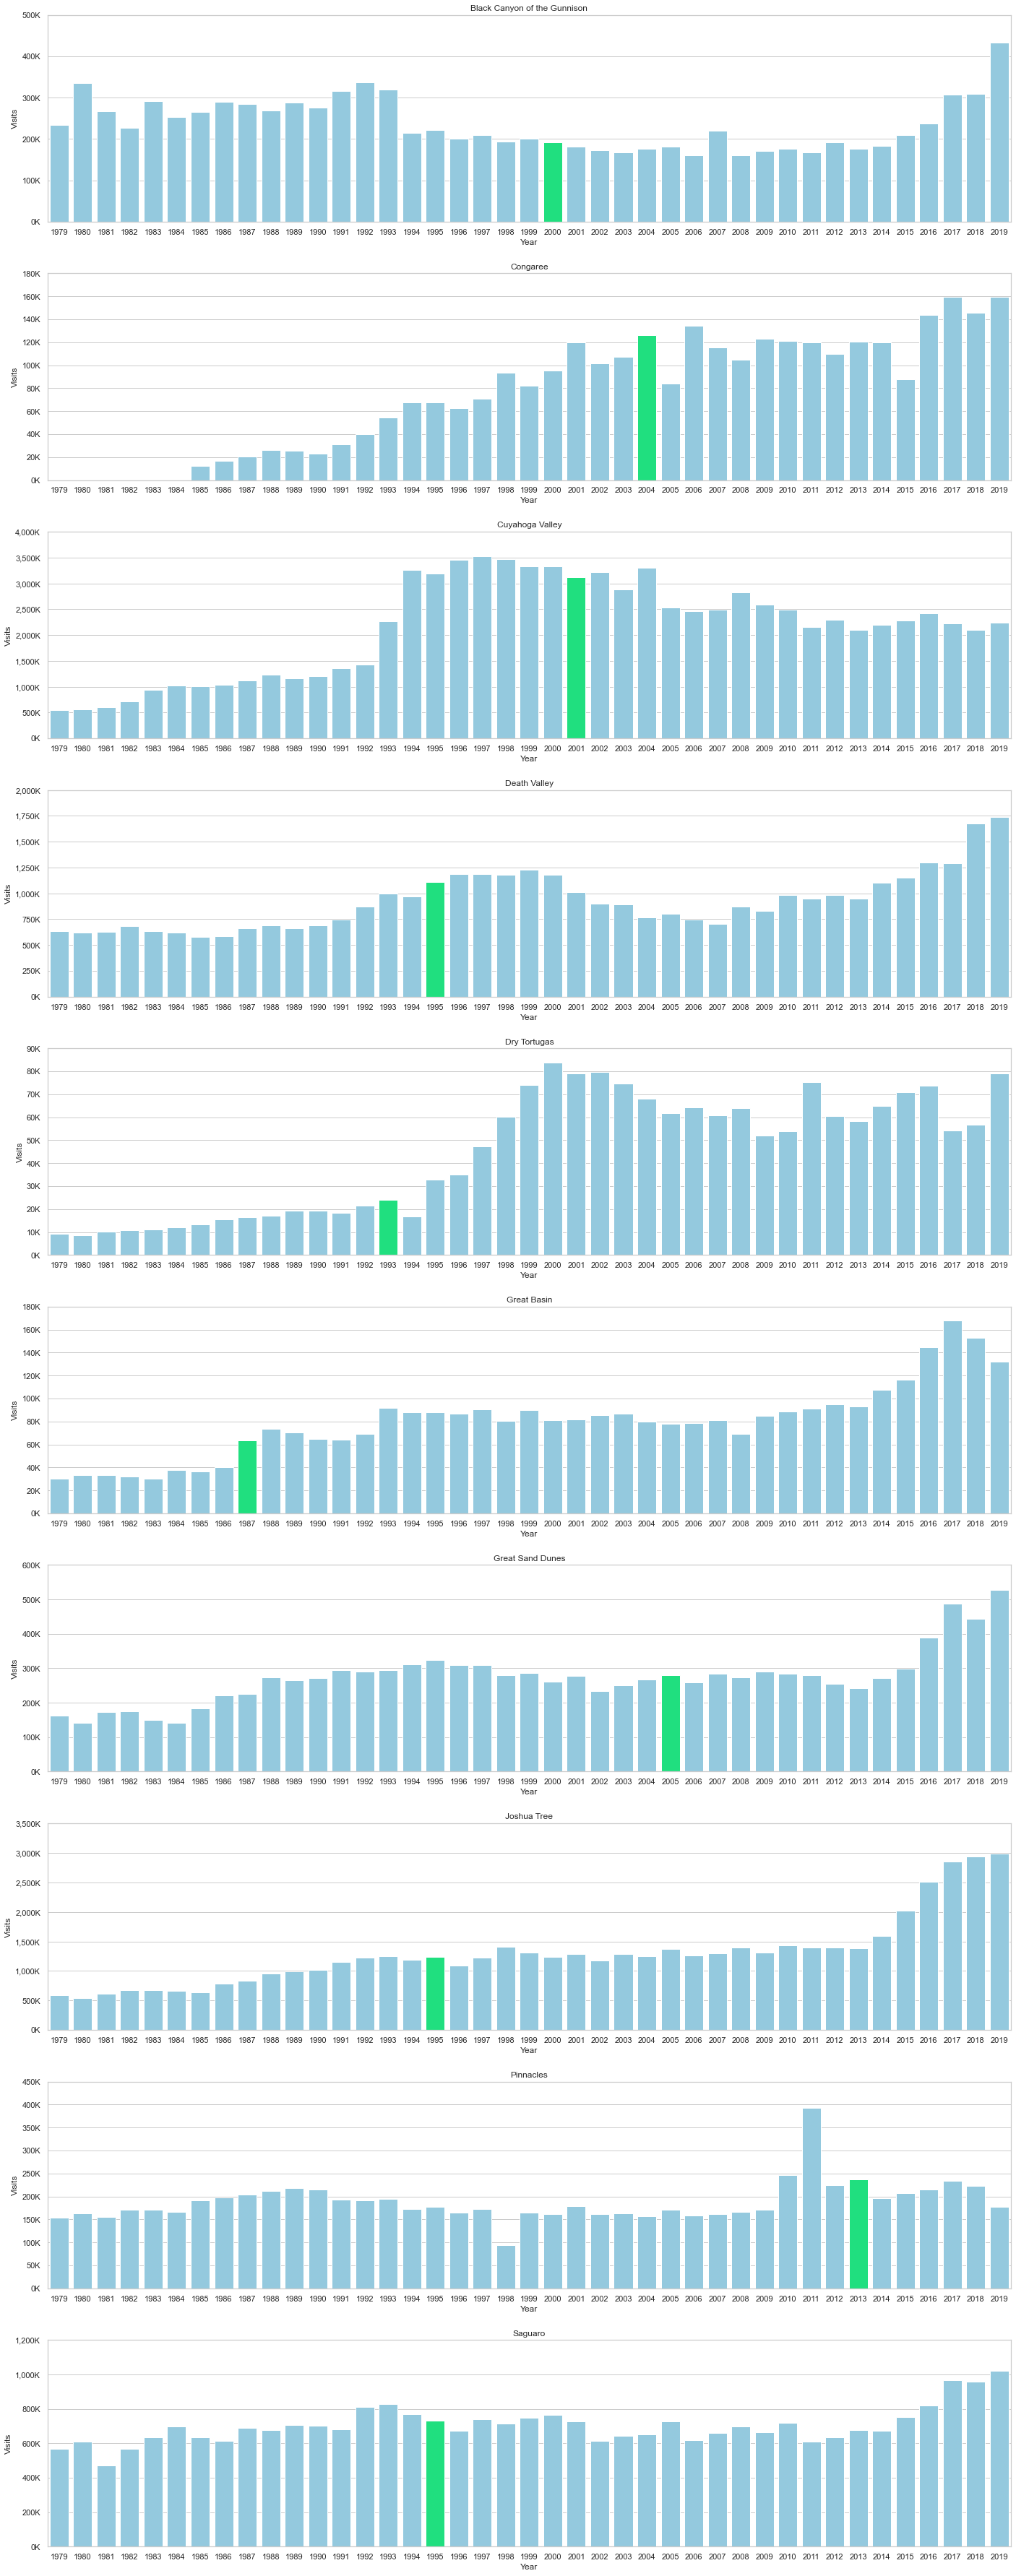

In [19]:
def barplot_annual_visits(park_data_combined_df):
    # Calculate the plot grid rows.
    num_parks = park_data_combined_df.shape[0]

    # Setup the plot grid.  The width is fixed at 20 and the height is 5 for each row.
    _, axes = plt.subplots(nrows=num_parks, figsize=(20, num_parks * 5), tight_layout=dict(pad=2.0))

    # Plot each park's annual visit counts.
    # Color the bar green on the First Year the park was a National Park
    for i, (_, row) in enumerate(park_data_combined_df.iterrows()):
        # Calculate the axis for this park
        current_ax = axes[i]

        # Create the Barplot and set the title.  Bar colors are blue for all years except the first year the park was a National Park (which will be green).
        colors = ["skyblue" if x!=row['First Year'] else 'springgreen' for x in park_data_melted_df['Year']]
        sns.barplot(data=park_data_melted_df[park_data_melted_df['Name'] == row['Name']], x='Year', y='Visits', palette=colors, ax = current_ax)
        current_ax.set_title(row['Name'])

        # Format the visit ticks to be in thousandths for better readability
        ylabels = ['{:,.0f}'.format(y) + 'K' for y in current_ax.get_yticks()/1000]
        current_ax.set_yticks(current_ax.get_yticks())  ## Only do this to suppress warning about setting tick labels without setting ticks
        current_ax.set_yticklabels(ylabels)

barplot_annual_visits(park_data_combined_df)

#### Examine YoY Increases
The barplots are an improvement over the lineplots.  There still doesn't seem to be a correlation between visits and the year a park became a national park.  
Let's drill one level further to make sure we aren't missing anything.  Looking at YoY increases (or decreases), rather than raw values, should tell a better story.

***
Calculate the year-over-year (YoY) changes.
***

In [20]:
def add_yoy_changes(park_data_melted_df):
    # Use the pct_change function to add the change in visits in each year.  Replace inf and -inf with NaN.
    park_data_melted_df['Visits Delta'] = park_data_melted_df['Visits'].pct_change()
    park_data_melted_df['Visits Delta'] = park_data_melted_df['Visits Delta'].replace([np.inf, -np.inf], np.nan)

    # Return modified melted dataframe
    return park_data_melted_df

park_data_melted_df = add_yoy_changes(park_data_melted_df)
display(park_data_melted_df.head())

,Name,First Year,Year,Visits,Visits Delta
0,Black Canyon of the Gunnison,2000,1979,234286,NaN
10,Black Canyon of the Gunnison,2000,1980,336119,0.434653
20,Black Canyon of the Gunnison,2000,1981,266604,-0.206817
30,Black Canyon of the Gunnison,2000,1982,227428,-0.146945
40,Black Canyon of the Gunnison,2000,1983,291618,0.282243


***
Plot the YoY changes for the three years before and the three years after each park became a National Park.
*** 

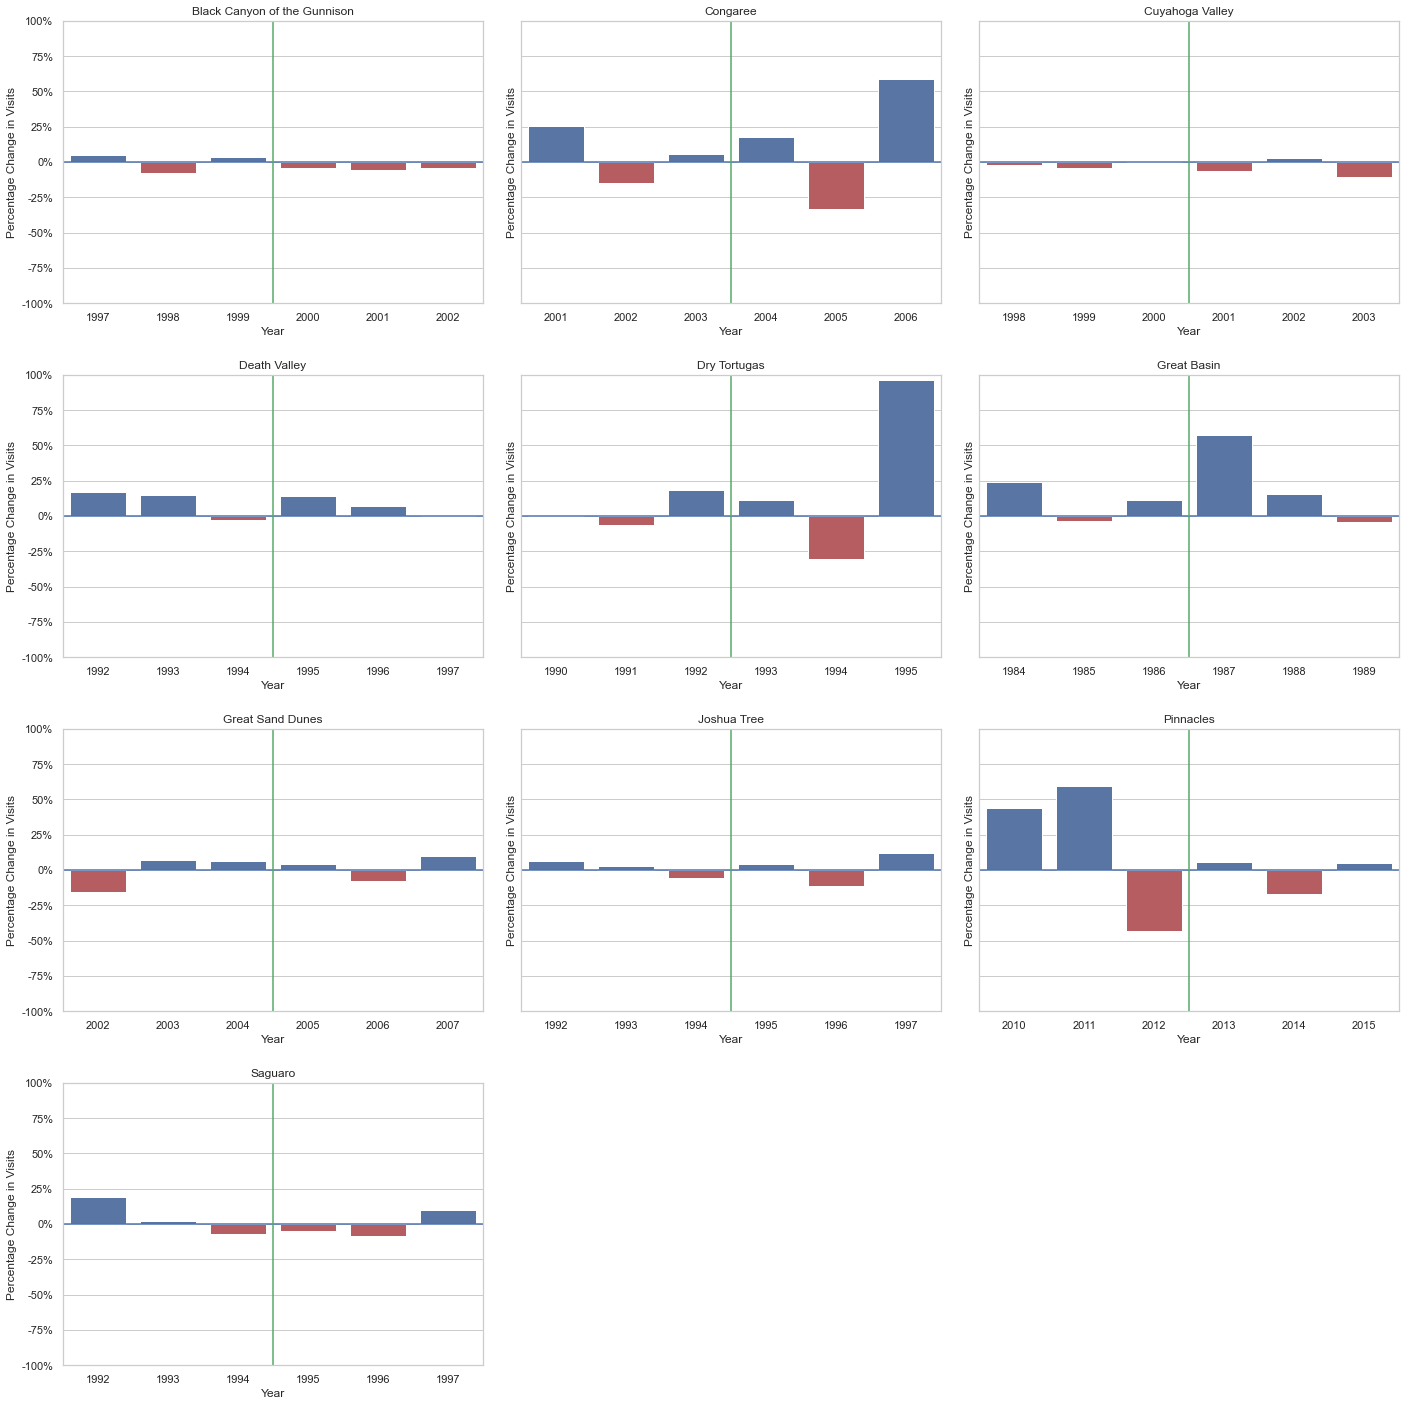

In [21]:
def plot_yoy_changes(park_data_combined_df, park_data_melted_df):
    # Calculate the plot grid rows.  Columns are fixed at 3.
    num_parks = park_data_combined_df.shape[0]
    num_cols = 3
    num_rows = int(num_parks / num_cols) + 1

    # Setup the plot grid.  The width is fixed at 20 and the height is 5 for each row.
    fig, axes = plt.subplots(num_rows, num_cols, sharey = True, figsize=(20,num_rows * 5), tight_layout=dict(pad=2.0))

    # Plot the change in each park's annual visit counts.
    for i, (index, row) in enumerate(park_data_combined_df.iterrows()):
        # Calculate the axis for this park
        ax_row, ax_column = divmod(i, num_cols)
        current_ax = axes[ax_row][ax_column]

        # Create the Barplot and set the title.  Bar colors are blue for increases and red for decreases.
        colors = ['b' if y >= 0 else 'r' for y in park_data_melted_df[park_data_melted_df['Name'] == row['Name']]['Visits Delta']]
        sns.barplot(data=park_data_melted_df[park_data_melted_df['Name'] == row['Name']], x='Year', y='Visits Delta', palette=colors, ax = current_ax)
        current_ax.set_title(row['Name'])
        
        # Set X limits based on the First Year the park was a National Park (3 years before and 3 years after)
        first_year = row['First Year']
        first_year_offset = first_year - base_year
        current_ax.set_xlim(first_year_offset - 3.5, first_year_offset + 2.5)

        # Set the Y limits to be +/- 100% and set the Y label
        current_ax.set_ylim(-1, 1)
        current_ax.set_ylabel('Percentage Change in Visits')

        # Format the % change ticks as percentages for better readability
        ylabels = ['{:,.0f}'.format(y) + '%' for y in current_ax.get_yticks()*100]
        current_ax.set_yticks(current_ax.get_yticks())  ## Only do this to suppress warning about setting tick labels without setting ticks
        current_ax.set_yticklabels(ylabels)

        # Add a horizontal blue line at y=0 and and a vertical green line at the start of the year when the park became a National Park.
        current_ax.axhline(y=0, color='b')
        current_ax.axvline(x=first_year_offset - .5, color='g')

    # The last row might have some extra axes we need to turn off
    for i in range(num_parks, num_rows*num_cols):
        ax_row, ax_column = divmod(i, num_cols)
        current_ax = axes[ax_row][ax_column]
        current_ax.axis('off')

plot_yoy_changes(park_data_combined_df, park_data_melted_df)

***
### Conclusion

It appears our initial hypothesis is not true and annual visits do not increase simply by a park being officially designated as a National Park.  
For a final summary view, we will create a single chart showing a three year rolling average of YoY increases/decreases before and after a park achieves a National Park designation.

In [22]:
def generate_final_summary(park_data_melted_df):
    # Use the rolling and mean functions to add a column to hold the three year rolling average of annual increases to each year.
    park_data_melted_df['Rolling Delta'] = park_data_melted_df['Visits Delta'].rolling(3).mean()

    # Filter the dataframe to only the three year rolling average the year immediately prior to the park being a National Park (First Year - 1) and three years after (First Year + 2)
    park_data_melted_df_small = park_data_melted_df[(park_data_melted_df['Year'] == (park_data_melted_df['First Year'] -1)) | (park_data_melted_df['Year'] == (park_data_melted_df['First Year'] + 2))]
    cols = ['Name', 'First Year', 'Year', 'Rolling Delta']
    park_data_melted_df_small = park_data_melted_df_small[cols]

    conditions = [(park_data_melted_df_small['Year'] == park_data_melted_df_small['First Year'] -1), (park_data_melted_df_small['Year'] == park_data_melted_df_small['First Year'] + 2)]
    values = ['Prior 3 Yr Avg', 'Post 3 Yr Avg']
    park_data_melted_df_small['Period'] = np.select(conditions, values)

    park_visits_final_df = park_data_melted_df_small.pivot(index=['Name', 'First Year'], columns='Period')
    park_visits_final_df.drop('Year', axis=1, inplace=True)
    park_visits_final_df = park_visits_final_df.droplevel(0, axis=1).reset_index()
    park_visits_final_df.columns.name = None
    park_visits_final_df['Display Name'] = park_visits_final_df['Name'] + " (" + park_visits_final_df['First Year'].astype(str) + ")"
    park_visits_final_df.set_index('Name', inplace=True)

    park_visits_final_df['Change in 3 Yr Avg'] = park_visits_final_df['Post 3 Yr Avg'] - park_visits_final_df['Prior 3 Yr Avg']
    park_visits_final_df = park_visits_final_df[['First Year', 'Prior 3 Yr Avg', 'Post 3 Yr Avg', 'Change in 3 Yr Avg', 'Display Name']]
    park_visits_final_df.sort_values(by='First Year', inplace=True)
    final_output = park_visits_final_df.style.format({
        'Prior 3 Yr Avg': '{:,.2%}'.format,
        'Post 3 Yr Avg': '{:,.2%}'.format,
        'Change in 3 Yr Avg': '{:,.2%}'.format
    })

    display(final_output)
    return park_visits_final_df

final_summary_df = generate_final_summary(park_data_melted_df)


,First Year,Prior 3 Yr Avg,Post 3 Yr Avg,Change in 3 Yr Avg,Display Name
Name,,,,,
Great Basin,1987,10.57%,22.90%,12.33%,Great Basin (1987)
Dry Tortugas,1993,4.05%,25.79%,21.75%,Dry Tortugas (1993)
Death Valley,1995,9.69%,7.10%,-2.58%,Death Valley (1995)
Joshua Tree,1995,1.26%,1.63%,0.37%,Joshua Tree (1995)
Saguaro,1995,4.78%,-0.97%,-5.76%,Saguaro (1995)
Black Canyon of the Gunnison,2000,0.17%,-4.61%,-4.78%,Black Canyon of the Gunnison (2000)
Cuyahoga Valley,2001,-1.94%,-4.52%,-2.58%,Cuyahoga Valley (2001)
Congaree,2004,5.17%,14.55%,9.38%,Congaree (2004)
Great Sand Dunes,2005,-0.68%,2.46%,3.14%,Great Sand Dunes (2005)


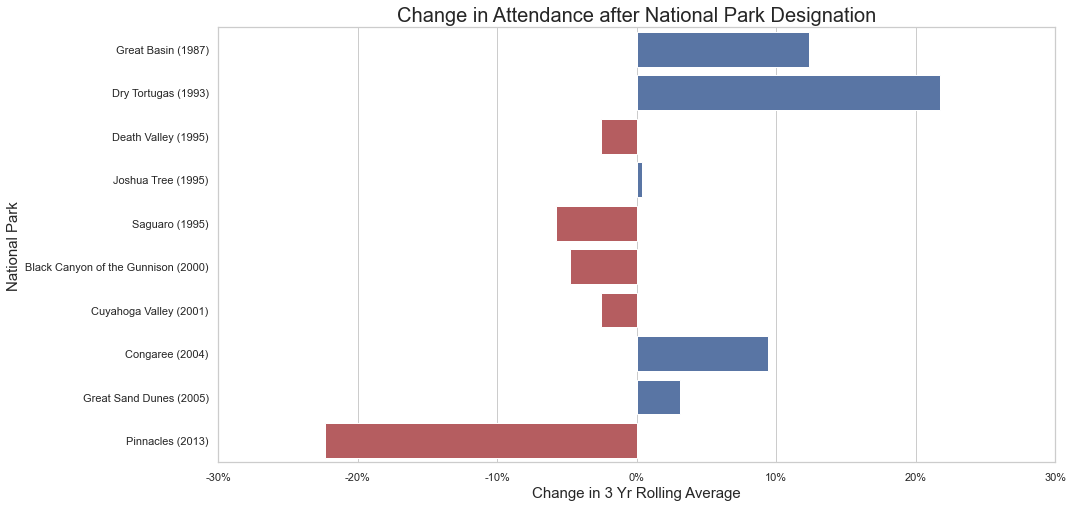

In [23]:
def graph_summary_visit_change(final_summary_df):
    # Create the Barplot and set the title.  Bar colors are blue for increases and red for decreases.
    cmap = (final_summary_df['Change in 3 Yr Avg'] > 0).map({True: 'b', False: 'r'})
    ax = sns.barplot(data=final_summary_df, x='Change in 3 Yr Avg', y='Display Name', palette=cmap)
    ax.set_title('Change in Attendance after National Park Designation', fontsize=20)

    # Format the % change ticks as percentages for better readability    
    xlabels = ['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()*100]
    ax.set_xticks(ax.get_xticks())  ## Only do this to suppress warning about setting tick labels without setting ticks
    ax.set_xticklabels(xlabels)

    # Label Axes
    ax.set_ylabel('National Park', fontsize=15)
    ax.set_xlabel('Change in 3 Yr Rolling Average', fontsize=15)

graph_summary_visit_change(final_summary_df)

***
### Afterthoughts

Although initial analysis of this data is complete, the data collected can serve as the foundation for further investigation...
 - How does the weather impact monthly visitation?
 - How does the age of a national park impact annual visitation?
 - How does the area-size of a national park impact annual visitation?
